In [1]:
import numpy as np
from scipy.linalg import toeplitz
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from fippy.explainers import Explainer
from fippy.samplers import GaussianSampler
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd


np.random.seed(12345)
seed=12345

/home/mind/areyerol/.local/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-11 09:58:38,193	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-06-11 09:58:38,367	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
# Data generation
def sample_gaussian_toeplitz(n, p, rho):
    # Step 1: Create Toeplitz covariance matrix
    cov = toeplitz([rho**i for i in range(p)])
    
    # Step 2: Sample from multivariate normal
    mean = np.zeros(p)
    samples = np.random.multivariate_normal(mean, cov, size=n)
    
    return samples


## create data
n = 10000
p = 2

x = sample_gaussian_toeplitz(n=n, p=p, rho=0.6)
y = x[:,0] + np.random.normal(0, 1, n)

## -------------------------------------------------------------
## preliminary step: get regression estimators
## -------------------------------------------------------------
## use grid search to get optimal number of trees and learning rate
ntrees = np.arange(100, 500, 100)
lr = np.arange(.01, .1, .05)

param_grid = [{'n_estimators':ntrees, 'learning_rate':lr}]

## set up cv objects
cv_full = GridSearchCV(GradientBoostingRegressor(loss = 'squared_error', max_depth = 1), param_grid = param_grid, cv = 5)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

feature_names = [f"X{i}" for i in range(X_train.shape[1])]
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)
y_test_df = pd.DataFrame(y_test)
y_train_df = pd.DataFrame(y_train)

cv_full.fit(X_train_df, y_train)
 
sampler = GaussianSampler(X_train_df)
wrk = Explainer(cv_full.predict, X_train_df, loss=mean_squared_error, sampler=sampler)

In [4]:
#mSAGE
ex_msage, orderings = wrk.msage(X_test_df, y_test_df, nr_resample_marginalize=50, nr_orderings=40, nr_runs = 100)
ex_msage.ex_name = 'msage'


# cSAGE 
ex_csage, orderings = wrk.csage(X_test_df, y_test_df, nr_resample_marginalize=50, nr_orderings=40, nr_runs = 100)
ex_csage.ex_name = 'csage'


Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find

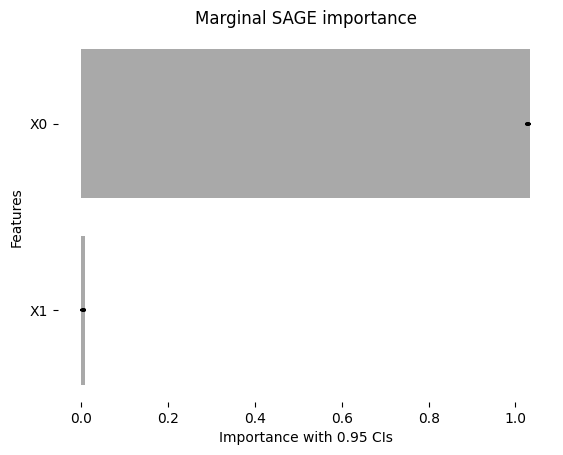

In [5]:
ex_msage.hbarplot()
plt.title('Marginal SAGE importance')
plt.show()

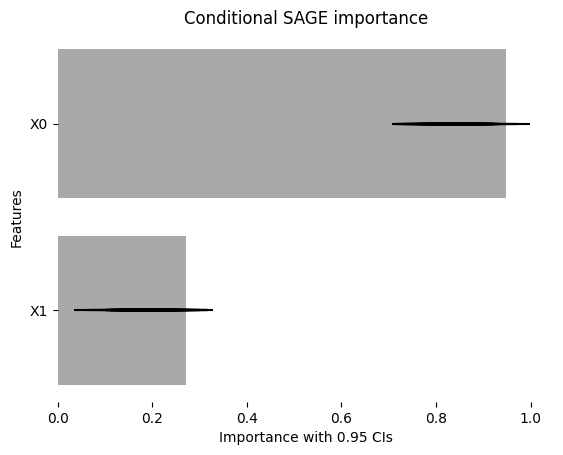

In [6]:
ex_csage.hbarplot()
plt.title('Conditional SAGE importance')
plt.show()

In [7]:
ex_msage.fi_means_stds()

X0                                         1.028621
X1                                           0.0042
std    X0    0.001523
X1    0.001456
dtype: float64
dtype: object

In [8]:
ex_csage.fi_means_stds()

X0                                         0.839273
X1                                         0.193724
std    X0    0.033038
X1    0.033237
dtype: float64
dtype: object

In [9]:
data = []
for method_name, series in zip(['MSAGE', 'CSAGE'], [ex_msage.fi_means_stds(), ex_csage.fi_means_stds()]):
    means = series.drop('std')
    stds = series['std']
    for var in ['X0', 'X1']:
        data.append({'Variable': var, 'Method': method_name, 'Mean': means[var], 'Std': stds[var]})

df_plot = pd.DataFrame(data)

/tmp/ipykernel_89218/1617015636.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=df_plot, x='Variable', y='Mean', hue='Method', ci=None, capsize=0.1)


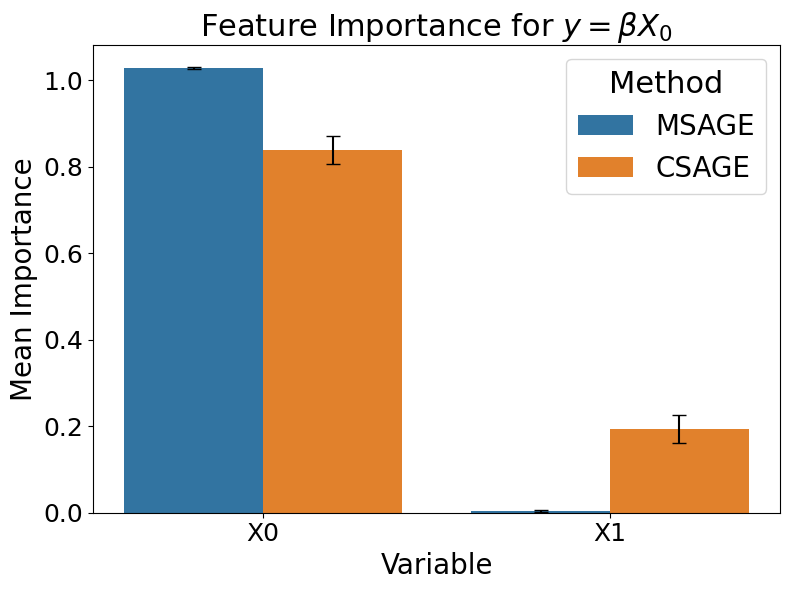

In [11]:
import seaborn as sns

plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df_plot, x='Variable', y='Mean', hue='Method', ci=None, capsize=0.1)

# Add error bars manually
for i, row in df_plot.iterrows():
    x_pos = list(df_plot['Variable'].unique()).index(row['Variable']) + (-0.2 if row['Method'] == 'MSAGE' else 0.2)
    ax.errorbar(x=x_pos, y=row['Mean'], yerr=row['Std'], fmt='none', c='black', capsize=5)

plt.title(r'Feature Importance for $y=\beta X_0$', fontsize=22)
plt.ylabel('Mean Importance', fontsize=20)
plt.xlabel('Variable', fontsize=20)
plt.legend(title='Method', fontsize=20, title_fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig("../results/figures/motivating_example.pdf")
plt.show()
